# Evasion Attacks against Neural Networks on MNIST dataset

Let's continue from the [Neural Networks tutorial](02-NeuralNetworks.ipynb),
using the MNIST dataset this time. We can use a convolutional neural network, 
but we need to take care of reshaping the input to the expected input size,
in this case (-1, 1, 28, 28). We will see in the following how to use 
torchvision's `transforms` module for this purpose.

In [1]:
import torch
from torch import nn

class MNISTNet(nn.Module):
    """
    Model with input size (-1, 28, 28) for MNIST dataset.
    """
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 3)

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

Now we can load MNIST dataset. Remember the input shape is `(1, 1, 28, 28)`, 
using NCHW convention.

The input shape is an input parameter of the wrapper, since it has to take 
care of input reshaping before passing it to the neural network.

In [2]:
n_samples_tr = 6000  # number of training set samples
n_samples_ts = 1000  # number of testing set samples

from secml.data.loader import CDataLoaderMNIST
digits = (1, 5, 9)
dataset = CDataLoaderMNIST().load('training', digits=digits)

# Split in training and test
from secml.data.splitter import CTrainTestSplit
splitter = CTrainTestSplit(train_size=n_samples_tr, 
                           test_size=n_samples_ts,
                           random_state=0)
tr, ts = splitter.split(dataset)

# Normalize the data
tr.X /= 255
ts.X /= 255

Now we can use again the `CClassifierPyTorch` wrapper for having the model 
accessible with our library. Note that we pass the input shape as input 
parameter for the wrapper.

In [3]:
from torch import optim

# Random seed
torch.manual_seed(0)

net = MNISTNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),
                      lr=0.001, momentum=0.9)

from secml.ml.classifiers import CClassifierPyTorch
clf = CClassifierPyTorch(model=net,
                         loss=criterion,
                         optimizer=optimizer,
                         epochs=20,
                         batch_size=20,
                         input_shape=(1, 28, 28),
                         random_state=0)

We fit the model in the same way as before.

In [4]:
print("Training started...")
clf.fit(tr)
print("Training completed!")

Training started...
Training completed!


And now we can check how well we can classify the digits.

In [5]:
label_torch = clf.predict(ts.X, return_decision_function=False)

from secml.ml.peval.metrics import CMetric
metric = CMetric.create('accuracy')
acc_torch = metric.performance_score(ts.Y, label_torch)

print("Model Accuracy: {}".format(acc_torch))

Model Accuracy: 0.994


## Crafting Evasion Attacks

We can now create, as we did in notebook [MNIST tutorial](06-MNIST_dataset.ipynb), 
adversarial examples against the neural network we just trained.
The code is similar to the other notebook, the only difference will be 
the classifier that we pass to the `CAttackEvasionPGDLS` object.

In [6]:
# For simplicity, let's attack a subset of the test set
attack_ds = ts[:10, :]

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 3.5  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5, 
    'eta_min': 2.0, 
    'eta_max': None,
    'max_iter': 100, 
    'eps': 1e-6
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=clf,
                                    surrogate_classifier=clf,
                                    surrogate_data=tr,
                                    distance=noise_type, 
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(
    attack_ds.X, attack_ds.Y, double_init=True)
print("Attack complete!")

Attack started...
Attack complete!


In [7]:
acc = metric.performance_score(
    y_true=attack_ds.Y, y_pred=clf.predict(attack_ds.X))
acc_attack = metric.performance_score(
    y_true=attack_ds.Y, y_pred=eva_y_pred)

print("Accuracy on reduced test set before attack: {:.2%}".format(acc))
print("Accuracy on reduced test set after attack: {:.2%}".format(acc_attack))

Accuracy on reduced test set before attack: 100.00%
Accuracy on reduced test set after attack: 10.00%


Finally, we can display the adversarial digit along with its label.

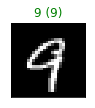

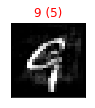

In [8]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

# Let's define a convenience function to easily plot the MNIST dataset
def show_digits(samples, preds, labels, digs, n_display=8):
    samples = samples.atleast_2d()
    n_display = min(n_display, samples.shape[0])
    fig = CFigure(width=n_display*2, height=3)
    for idx in range(n_display):
        fig.subplot(2, n_display, idx+1)
        fig.sp.xticks([])
        fig.sp.yticks([])
        fig.sp.imshow(samples[idx, :].reshape((28, 28)), cmap='gray')
        fig.sp.title("{} ({})".format(digits[labels[idx].item()], digs[preds[idx].item()]),
                     color=("green" if labels[idx].item()==preds[idx].item() else "red"))
    fig.show()

show_digits(attack_ds.X[0, :], clf.predict(attack_ds.X[0, :]), attack_ds.Y[0, :], digits)
show_digits(eva_adv_ds.X[0, :], clf.predict(eva_adv_ds.X[0, :]), eva_adv_ds.Y[0, :], digits)